In [1]:
!nvidia-smi

Fri Jun  2 10:37:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-06-02 10:37:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   230MB/s    in 0.7s    

2023-06-02 10:37:07 (230 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpath}'")

There are 2 directories and 0 in '10_food_classes_10_percent'
There are 10 directories and 0 in '10_food_classes_10_percent/train'
There are 0 directories and 75 in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 in '10_food_classes_10_percent/train/grilled_salmon'
There are 10 directories and 0 in '10_food_classes_10_percent/test'
There are 0 d

### Data loaders (preparing the data)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Test Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


In [5]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [8]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [9]:
def create_model(model_url, num_classes=10):

    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))
    

    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [10]:
resnet_model = create_model(resnet_url, train_data_10_percent.num_classes)

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(
                                                dir_name="tensorflow_hub",
                                                experiment_name="resnet-v2-50")])

Saving TensorBoard log files to: tensorflow_hub/resnet-v2-50/20230602-103752
Epoch 1/5
24/24 [==============================] - 29s 543ms/step - loss: 1.9422 - accuracy: 0.3333 - val_loss: 1.2199 - val_accuracy: 0.6044
Epoch 2/5
24/24 [==============================] - 10s 429ms/step - loss: 0.9231 - accuracy: 0.7293 - val_loss: 0.8820 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 10s 436ms/step - loss: 0.6373 - accuracy: 0.8093 - val_loss: 0.7666 - val_accuracy: 0.7436
Epoch 4/5
24/24 [==============================] - 11s 466ms/step - loss: 0.4698 - accuracy: 0.8747 - val_loss: 0.7055 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 11s 453ms/step - loss: 0.3762 - accuracy: 0.9133 - val_loss: 0.6840 - val_accuracy: 0.7692


In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_history_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(loss))

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

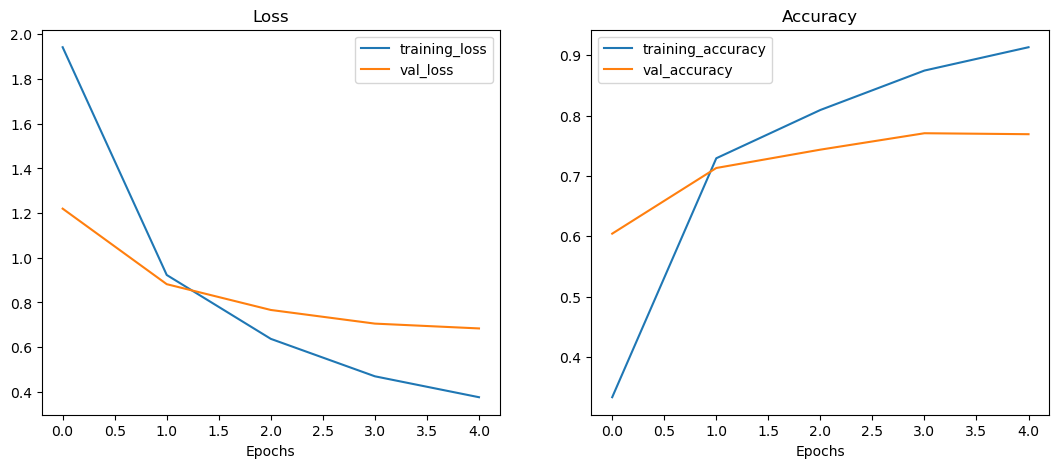

In [14]:
plot_history_curves(resnet_history)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
efficient_model = create_model(model_url=efficient_url, 
                               num_classes=train_data_10_percent.num_classes)

In [17]:
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [18]:
efficient_history = efficient_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensorboard_callback(
                                            dir_name="tensorflow_hub",
                                            experiment_name="efficient-b0(correct)")])

Saving TensorBoard log files to: tensorflow_hub/efficient-b0(correct)/20230602-103934
Epoch 1/5
24/24 [==============================] - 27s 653ms/step - loss: 1.7719 - accuracy: 0.5027 - val_loss: 1.2628 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 10s 417ms/step - loss: 1.0397 - accuracy: 0.7680 - val_loss: 0.8607 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 10s 437ms/step - loss: 0.7543 - accuracy: 0.8200 - val_loss: 0.6951 - val_accuracy: 0.8480
Epoch 4/5
24/24 [==============================] - 10s 426ms/step - loss: 0.6115 - accuracy: 0.8667 - val_loss: 0.6104 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 10s 424ms/step - loss: 0.5152 - accuracy: 0.8960 - val_loss: 0.5578 - val_accuracy: 0.8636


In [19]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


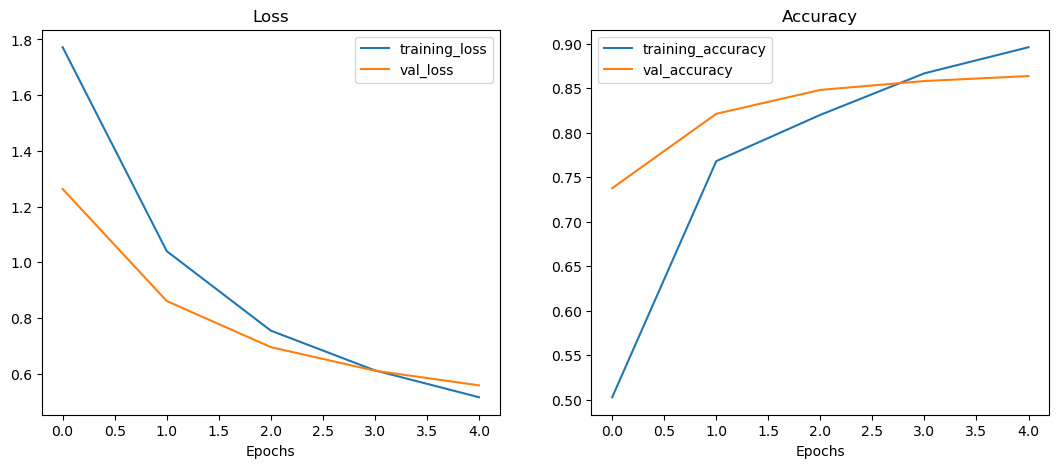

In [20]:
plot_history_curves(history=efficient_history)

In [21]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"

In [22]:
mobilenet_model = create_model(model_url=mobilenet_url, num_classes=train_data_10_percent.num_classes)

In [23]:
mobilenet_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [24]:
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_percent),
                   validation_data=test_data,
                   validation_steps=len(test_data),
                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="mobilenet-v2-100-224")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet-v1-100-224/20230602-104048
Epoch 1/5
24/24 [==============================] - 15s 445ms/step - loss: 2.2450 - accuracy: 0.3280 - val_loss: 1.1696 - val_accuracy: 0.6108
Epoch 2/5
24/24 [==============================] - 10s 408ms/step - loss: 0.8849 - accuracy: 0.7147 - val_loss: 0.7983 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 12s 534ms/step - loss: 0.6153 - accuracy: 0.8133 - val_loss: 0.6914 - val_accuracy: 0.7720
Epoch 4/5
24/24 [==============================] - 9s 397ms/step - loss: 0.4628 - accuracy: 0.8667 - val_loss: 0.6614 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 10s 423ms/step - loss: 0.3661 - accuracy: 0.9107 - val_loss: 0.6401 - val_accuracy: 0.7776


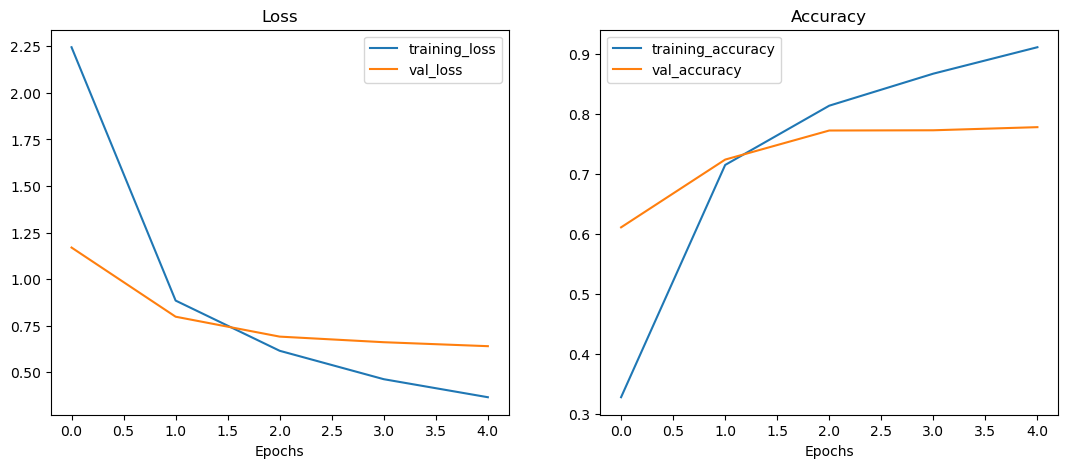

In [25]:
plot_history_curves(history=mobilenet_history)

In [26]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             3540265   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 3,550,285
Trainable params: 10,020
Non-trainable params: 3,540,265
_________________________________________________________________


In [34]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#     --name "EfficientNet-b0 vs. ResNet50v2 vs. mobilenet-v2-100-224" \
#     --description "Comparison between three hub models with 10% food image data with 10 food classification" \
#     --one_shot

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#     --name "EfficientNet-b0 vs. ResNet50v2" \
#     --description "Comparing two hub models with 10% food image data with 10 food classification" \
#     --one_shot

Tensorboard Link: https://tensorboard.dev/experiment/8hgzWroWSMejv5S48oGJYA/

In [ ]:
# !tensorboard dev list